### Iris Flower - Batch Prediction

+ Take some new input data and make some predictions with that new data
+ We will write our predictions back to the feature store
+ Output some assets that will be shown by streamlit UI

In [21]:
import pandas as pd
import hopsworks
import joblib

In [22]:
# Login
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/70809
Connected. Call `.close()` to terminate connection gracefully.


In [23]:
# Get the model from the model registry
mr = project.get_model_registry()
model = mr.get_model("sklearn_iris", version=1)
model_dir = model.download()

Connected. Call `.close()` to terminate connection gracefully.


In [24]:
# Load the load the downloaded model
model = joblib.load(model_dir + "/iris_model.pkl")

Now we will download the iris data from the feature view.

Recall that this is the raw data with no transformation

In [25]:
feature_view = fs.get_feature_view(name="sklearn_iris_dataset", version=1)

Now we will do some **Batch Inference**. 

We will read all the input features that have arrived in the last 24 hours, and score them.

In [26]:
import datetime
from PIL import Image

batch_data = feature_view.get_batch_data()
batch_data.tail()

Finished: Reading data from Hopsworks, using Hive (5.02s) 


,sepal_length,sepal_width,petal_length,petal_width
149,4.931430,2.776000,5.563321,1.746924
150,6.927532,3.768837,4.670163,1.533406
151,5.190488,3.051881,4.700561,1.441109
152,5.762542,2.266797,5.086353,1.155345
153,5.402680,3.957419,1.394769,1.869420


In [27]:
# Make prediction
y_pred = model.predict(batch_data)

# y_pred

Now we will map the predictions to the actual names of the flower species

In [28]:
target = {
        0: "setosa",
        1: "versicolor",
        2: "virginica"
    }

In [29]:
# Convert predictions to a Pandas Series
y_pred_series = pd.Series(y_pred)

# Map numerical predictions to categorical values using the dictionary
mapped_y_pred_series = y_pred_series.map(target)

y_pred = mapped_y_pred_series.values
y_pred[-5:]

array(['virginica', 'versicolor', 'versicolor', 'versicolor', 'setosa'],
      dtype=object)

Take the last row and predict what it is

Batch prediction output is the last entry in the batch - it is output as a file 'latest_iris.png'

In [30]:
# Get the last y_pred prediction
flower = y_pred[y_pred.size-1]
# flower

'setosa'

In [31]:
# Get the path to the image with that name
flower_img = "images/" + flower + ".png"

In [32]:
# Now open the image
img = Image.open(flower_img) 

In [33]:
# Now save it for display. This will be used by the UI
img.save("pred_assets/latest_iris.png")

Get the actual flower

In [34]:
iris_fg = fs.get_feature_group(name="sklearn_iris_dataset", version=1)
df = iris_fg.read()
# df.tail()

Finished: Reading data from Hopsworks, using Hive (2.36s) 


,sepal_length,sepal_width,petal_length,petal_width,species
149,4.931430,2.776000,5.563321,1.746924,Virginica
150,6.927532,3.768837,4.670163,1.533406,virginica
151,5.190488,3.051881,4.700561,1.441109,versicolor
152,5.762542,2.266797,5.086353,1.155345,versicolor
153,5.402680,3.957419,1.394769,1.869420,setosa


In [35]:
# Locate the label
label = df.iloc[-1]["species"]
# label

'setosa'

In [36]:
# Save it for display in the UI
label_flower = "images/" + label + ".png"

img = Image.open(label_flower)            

img.save("pred_assets/actual_iris.png")

### Store predictions in prediction feature group

We now have our predicted and actual flower.

Now we need to store our predictions in a prediciton feature group

In [17]:
import pandas as pd

# Get/Create feature group (for the purpose of prediction)
monitor_fg = fs.get_or_create_feature_group(name="sklearn_iris_predictions",
                                  version=1,
                                  primary_key=["datetime"],
                                  description="Iris flower Prediction/Outcome Monitoring"
                                 )

Insert our latest prediction into our prediction feature group

In [37]:
from datetime import datetime
now = datetime.now().strftime("%m/%d/%Y, %H:%M:%S")

data = {
    'datetime': [now],
    "sepal_length": df.iloc[-1].loc["sepal_length"],
    "sepal_width": df.iloc[-1].loc["sepal_width"],
    "petal_length": df.iloc[-1].loc["petal_length"],
    "petal_width": df.iloc[-1].loc["petal_width"],
    'prediction': [flower],
    'actual_label': [label],
}
monitor_df = pd.DataFrame(data)
monitor_fg.insert(monitor_df)

Uploading Dataframe: 0.00% |          | Rows 0/1 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: sklearn_iris_predictions_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/70809/jobs/named/sklearn_iris_predictions_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x7f5780ef68f0>, None)

make sure the job finishes running before you read

Read the historical predictions that were made

In [38]:
monitor_df

,datetime,sepal_length,sepal_width,petal_length,petal_width,prediction,actual_label
0,"04/21/2024, 08:19:55",5.40268,3.957419,1.394769,1.86942,setosa,setosa


In [ ]:
import time

time.sleep(140)

In [39]:
history_df = monitor_fg.read()
history_df

Finished: Reading data from Hopsworks, using Hive (2.27s) 


,datetime,sepal_length,sepal_width,petal_length,petal_width,prediction,actual_label
0,"04/20/2024, 11:17:45",5.000000,3.400000,1.600000,0.400000,setosa,setosa
1,"04/20/2024, 11:36:33",6.927532,3.768837,4.670163,1.533406,versicolor,virginica
2,"04/20/2024, 11:38:49",6.927532,3.768837,4.670163,1.533406,versicolor,virginica
3,"04/20/2024, 11:44:43",5.190488,3.051881,4.700561,1.441109,versicolor,versicolor
4,"04/20/2024, 21:40:14",5.190488,3.051881,4.700561,1.441109,versicolor,versicolor
5,"04/20/2024, 21:46:07",5.762542,2.266797,5.086353,1.155345,versicolor,versicolor
6,"04/20/2024, 22:02:54",5.762542,2.266797,5.086353,1.155345,versicolor,versicolor
7,"04/20/2024, 22:19:14",5.762542,2.266797,5.086353,1.155345,versicolor,versicolor
8,"04/21/2024, 06:23:25",5.762542,2.266797,5.086353,1.155345,versicolor,versicolor
9,"04/21/2024, 06:46:03",5.762542,2.266797,5.086353,1.155345,versicolor,versicolor


Get the 5 most recent predictions from history_df
Save it as a dataframe image
This is an easy way to put it in the UI

In [41]:
import dataframe_image as dfi

df_recent = history_df.tail(5)
 
dfi.export(df_recent, 'pred_assets/df_recent.png', table_conversion = 'matplotlib')

Confusion matrix

In [42]:
from sklearn.metrics import confusion_matrix

predictions = history_df[['prediction']]
labels = history_df[['actual_label']]

results = confusion_matrix(labels, predictions)
print(results)

[[2 0 0]
 [0 9 0]
 [0 2 0]]


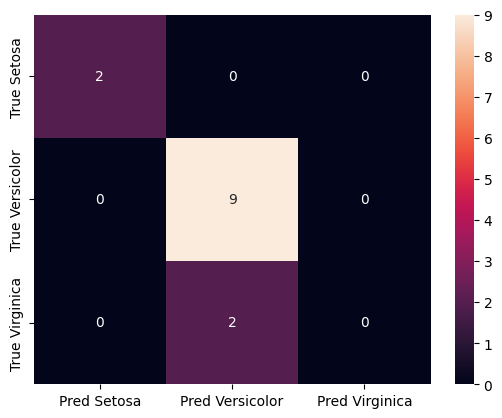

In [43]:
from matplotlib import pyplot
import seaborn as sns

# Only create the confusion matrix when our iris_predictions feature group has examples of all 3 iris flowers
if results.shape == (3,3):

    df_cm = pd.DataFrame(results, ['True Setosa', 'True Verhttps://github.blog/changelog/2023-09-22-github-actions-transitioning-from-node-16-to-node-20/sicolor', 'True Virginica'],
                         ['Pred Setosa', 'Pred Versicolor', 'Pred Virginica'])

    cm = sns.heatmap(df_cm, annot=True)

    fig = cm.get_figure()
    fig.savefig("pred_assets/confusion_matrix.png") 
    df_cm
else:
    print("Run the batch inference pipeline more times until you get 3 different iris flowers")    